### 导包

In [1]:
import random
import matplotlib.pyplot as plt
import keras
import os
from keras_bert import load_vocabulary
import numpy as np
from keras.models import Input, Model, load_model,Sequential
from keras.layers import LSTM, Dropout, Dense, Flatten, Bidirectional, Embedding, GRU,Lambda
from keras.optimizers import Adam
import keras.utils as ku 
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertModel
from keras_bert import load_trained_model_from_checkpoint, Tokenizer

### 定义Config

In [2]:
class Config(object):
    poetry_file = '../Datasets/poetry_7_1_(wufuhao).txt' # 训练数据
    weight_file = '../model/BERT+BiLSTM+LSTM_wufuhao.h5' # 模型存储
    max_len = 768
    batch_size = 32
    learning_rate = 0.001 # 学习率
    epoch = 100



### 处理数据

In [3]:
puncs = [']', '[', '（', '）', '{', '}', '：', '《', '》'] # 将数据中的一些中文符号去除

# 处理数据
def preprocess_file(Config):
    
    files_content = ''
    with open(Config.poetry_file, 'r', encoding='utf-8') as f:
        for line in f:
            # 每行的末尾加上"]"符号代表一首诗结束
            for char in puncs:
                line = line.replace(char, "") # 处理无关的字符
            files_content += line.strip()+"\n" # 去除一行中首尾的空格符

    words = sorted(list(files_content)) # 获取语料文本中的字符
#     words.remove(']')
    # 获得词频
    counted_words = {}
    for word in words:
        if word in counted_words:
            counted_words[word] += 1
        else:
            counted_words[word] = 1

    # 去掉低频的字
    erase = []
    for key in counted_words:
        if counted_words[key] <= 2:
            erase.append(key)
#     for key in erase:
#         del counted_words[key]
    wordPairs = sorted(counted_words.items(), key=lambda x: -x[1]) #排序
#     wordPairs.insert(0,('mask','0'))
    words, _ = zip(*wordPairs) #zip() 函数用于将可迭代的对象作为参数，将对象中对应的元素打包成一个个元组，然后返回由这些元组组成的列表。
    # word到id的映射
    #enumerate() 函数用于将一个可遍历的数据对象(如列表、元组或字符串)组合为一个索引序列，同时列出数据和数据下标
    word2num = dict((c, i) for i, c in enumerate(words))
    num2word = dict((i, c) for i, c in enumerate(words))
    word2numF = lambda x: word2num.get(x, 0) # 函数
    return word2numF, word2num,num2word, words, files_content


### 搭建模型

In [4]:

class PoetryModel(object):

    def __init__(self, config):
        self.model = None
        self.do_train = True
        self.loaded_model = False
        self.config = config
        self.predictors = None
        self.label = None
        self.history = None
        self.tokenizer = BertTokenizer.from_pretrained("bert-base-chinese")
        self.bertmodel = BertModel.from_pretrained("bert-base-chinese")
        # 文件预处理
        self.word2numF,self.word2num,self.num2word, self.words, self.files_content = preprocess_file(
            self.config)
        self.dataset_preparation()
        self.predictors = np.load('../Datasets/predictors.npy')
        # print(self.predictors[0])
        # self.label = np.load('../Datasets/label.npy')
        print(len(self.label))
        # 如果模型文件存在则直接加载模型，否则开始训练
        if os.path.exists(self.config.weight_file):
            self.model = load_model(self.config.weight_file)
            self.model.summary()
        else:
            self.train()
        self.do_train = False
        self.loaded_model = True

    def sequences2numF(self,text):
        token_list = []
        for item in text:
            token_list.append(self.word2numF(item))
        return token_list

    def dataset_preparation(self):
        corpus = self.files_content.split("\n")
        print(corpus[0])
        total_words = len(self.num2word) + 1
        # create input sequences using list of tokens
        input_sequences = []
        for line in corpus:
            token_list = self.sequences2numF(line)
            for i in range(1, len(token_list)):
                n_gram_sequence = token_list[:i+1]
                input_sequences.append(n_gram_sequence)
 
        max_len = max([len(x) for x in input_sequences])
        print(max_len)
        input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_len, padding='pre'))
        print("00")
        # create predictors and label
        predictors, self.label = input_sequences[:,:-1],input_sequences[:,-1] #最后一个token为lable, 前面为predictor
        # self.predictors = self.CXL(predictors)
        # self.config.max_len = max([len(x) for x in self.predictors])
        self.label = ku.to_categorical(self.label, num_classes=total_words)

    def CXL(self,predictors):
        tmp = []
  
        for item in predictors:
            temp = self.tokenizer.convert_ids_to_tokens(item)
            text = ''
            for i in temp:
                if i < '\u4e00' or  i > '\u9fff':
                    continue
                text += i
            tokens = self.tokenizer.encode_plus(text=text, return_tensors='pt')
            model_out = self.bertmodel(**tokens)
            cxl = model_out[0][0][1]
            # print(text)
            for i in range(1,len(text)+1):
                cxl += model_out[0][0][i+1]
            cxl /= len(text)
            tmp.append(cxl.tolist())
        return np.array([tmp])

    def build_model(self):
        '''建立模型'''

        self.model = Sequential()
        # self.model.add(Embedding(input_dim = self.tokenizer.vocab_size+2, output_dim = 300,input_length=self.config.max_len))
        self.model.add(Bidirectional(LSTM(150, return_sequences=True))) # GRU LSTM 变体 
        self.model.add(LSTM(128))
        # self.model.add(Dropout(0.3))
        # self.model.add(Flatten())
        self.model.add(Dense(len(self.words)+1, activation='softmax'))
        optimizer = Adam(lr=self.config.learning_rate)
        self.model.compile(loss='categorical_crossentropy',
                           optimizer=optimizer, metrics=['accuracy'])
        self.model.build(input_shape=(None,None,768))

    # 根据给出的文字，生成诗句，需要给出后面预测的字数
    def generate_text(self, send_text,next_words):
        if not self.loaded_model:
            return

        res = ''  
        for _ in range(next_words):
            token_list = self.tokenizer.encode_plus(text=send_text)['input_ids'][1:-1]
            token_list = pad_sequences([token_list], maxlen=6, padding='pre')
            token_list = self.CXL(token_list)
            predicted = self.model.predict_classes(token_list, verbose=0)
            output_word = self.num2word.get(predicted[0])
            send_text += output_word
        return send_text
    
    # 根据给出的文字，生成藏头诗
    def generate_CTS(self, send_text):
        if not self.loaded_model:
            return

        for item in send_text:
            print (self.generate_text(item, 6)) 
            print()
    

    def train(self):
        '''训练模型'''
        number_of_epoch = self.config.epoch
        if not self.model:
            self.build_model()

        self.model.summary()
        self.history = self.model.fit(self.predictors,self.label,epochs=number_of_epoch,verbose=1,batch_size=self.config.batch_size)

    def show(self):
        plt.plot(self.history.history['loss'],label = 'train_loss')
        plt.title('loss')
        plt.legend()
        plt.show()

        plt.plot(self.history.history['accuracy'], label='training_accuracy')
        plt.title('Accuracy')
        plt.legend()
        plt.show()


In [5]:
model = PoetryModel(Config)

仓储十万发关中
7
00
60000


d:\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, None, 300)         1102800   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense (Dense)                (None, 4565)              588885    
Total params: 1,911,333
Trainable params: 1,911,333
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1875/1875 [==============================] - 14s 6ms/step - loss: 7.5249 - accuracy: 0.0066
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 7.3038 - accuracy: 0.0101
Epoch 3/100
1875/1875 [==============================] - 13s 7ms/step - loss: 7.1808 - accuracy: 0.0121
Epoch 4/100
1875/1875 [==============================] - 14s 8ms

In [10]:
## 扩展诗句
text = "君子"
num =  20
sentence = model.generate_text(text,num)
print(sentence)

d:\Programs\Python\Python38\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


君子逢与呼呼游僧守沙凭寇短短移风战出战自舟火


In [7]:
## 藏头诗
text = "自然语言处理"
sentence = model.generate_CTS(text)

自来诸君到别去

然逢有未风乐乐

语今读故闻今乐

言后不不名易不

处从地长极今有

理有来明前知万



In [8]:
model.model.save(model.config.weight_file)

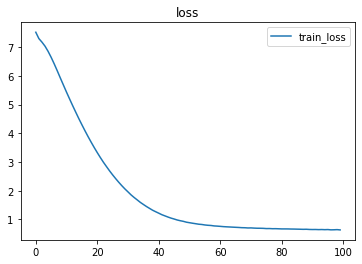

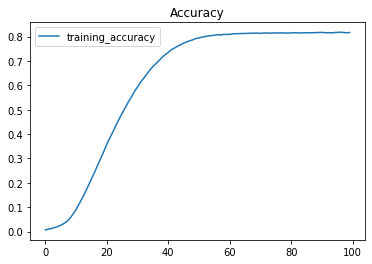

In [9]:
model.show()